In [1]:
import numpy as np
import strawberryfields as sf
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
#Cutoff dimension - don't need more than 10 modes in the simulation
cutoff_dim = 10
#Gate cutoff - don't want a single gate acting on more than cutoff_gate modes
cutoff_gate = 4
#Number of layers in the circuit
depth = 7
#Number of iterations during gradient descent
iterations = 200
#learning rate
learn_rate = 0.025
#Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

#Setting seeds for reproducibility
tf.random.set_seed(100)
np.random.seed(100)

'''The following code defines the gates in one layer of the circuit, and that layer
will get stacked depth times'''
#Squeezing gate
Xi_r = tf.random.normal(shape=[depth], stddev=active_sd)
Xi_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

#Displacement gate
Alpha_r = tf.random.normal(shape=[depth], stddev=active_sd)
Alpha_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

#Quadrature rotation gates
Rot1 = tf.random.normal(shape=[depth], stddev=passive_sd)
Rot2 = tf.random.normal(shape=[depth], stddev=passive_sd)

#Kerr gate
Kappa = tf.random.normal(shape=[depth], stddev=active_sd)

#Variational parameters in the gates
var_params = tf.convert_to_tensor([Rot1, Xi_r, Xi_phi, Rot2, Alpha_r, Alpha_phi, Kappa])
var_params = tf.Variable(tf.transpose(var_params))

#Sanity check for dimension of var_params tensor
print(var_params.shape == (depth, 7)) #7 because each layer has 7 gates, i.e., 7 parameters

True


In [4]:
#Circuit construction

#Single mode program
prog = sf.Program(1)

#This section of the code essentially creates the 7 optimizable parameters per layer of the circuit
sf_params = [] #list for variational parameters
names = ["Rot1", "Xi_r", "Xi_phi", "Rot2", "Alpha_r", "Alpha_phi", "Kappa"]

for i in range(depth):
    #For the ith layer, generate parameter names "Rot1_i", "Xi_r_i", etc.
    sf_params_names = ["{}_{}".format(n, i) for n in names]
    #Create the parameters, and append them to our list ``sf_params``.
    sf_params.append(prog.params(*sf_params_names))
sf_params = np.array(sf_params)
print(sf_params)
print(sf_params.shape == (depth, 7))

[[{Rot1_0} {Xi_r_0} {Xi_phi_0} {Rot2_0} {Alpha_r_0} {Alpha_phi_0}
  {Kappa_0}]
 [{Rot1_1} {Xi_r_1} {Xi_phi_1} {Rot2_1} {Alpha_r_1} {Alpha_phi_1}
  {Kappa_1}]
 [{Rot1_2} {Xi_r_2} {Xi_phi_2} {Rot2_2} {Alpha_r_2} {Alpha_phi_2}
  {Kappa_2}]
 [{Rot1_3} {Xi_r_3} {Xi_phi_3} {Rot2_3} {Alpha_r_3} {Alpha_phi_3}
  {Kappa_3}]
 [{Rot1_4} {Xi_r_4} {Xi_phi_4} {Rot2_4} {Alpha_r_4} {Alpha_phi_4}
  {Kappa_4}]
 [{Rot1_5} {Xi_r_5} {Xi_phi_5} {Rot2_5} {Alpha_r_5} {Alpha_phi_5}
  {Kappa_5}]
 [{Rot1_6} {Xi_r_6} {Xi_phi_6} {Rot2_6} {Alpha_r_6} {Alpha_phi_6}
  {Kappa_6}]]
True


In [5]:
#Just defining a layer as an operation so that it becomes easy to stack in the strawberry fields program
@sf.utils.operation(1)
def layer(i, q):
    sf.ops.Rgate(sf_params[i][0]) | q
    sf.ops.Sgate(sf_params[i][1], sf_params[i][2]) | q
    sf.ops.Rgate(sf_params[i][3]) | q
    sf.ops.Dgate(sf_params[i][4], sf_params[i][5]) | q
    sf.ops.Kgate(sf_params[i][6]) | q
    return q

#Defining the input state to the circuit
input_state = np.zeros([cutoff_gate, cutoff_dim])
np.fill_diagonal(input_state, 1)
print(input_state)

# Apply circuit of layers with corresponding depth
with prog.context as q:
    sf.ops.Ket(input_state) | q
    for j in range(depth):
        layer(j) | q[0]

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [6]:
#Target unitary to design a circuit for - taken from the tutorial
Unitary = np.array([[ 0.2365-0.4822j,  0.0683+0.0445j,  0.5115-0.0953j,  0.5521-0.3597j],\
                  [-0.1115+0.6978j, -0.2494+0.0841j,  0.4671-0.4319j,  0.1622-0.0182j],\
                  [-0.2235-0.2592j,  0.2436-0.0538j, -0.0926-0.5381j,  0.2727+0.6694j],\
                  [ 0.1152-0.286j,  -0.9016-0.221j,  -0.0963-0.1311j, -0.02  +0.1277j]], dtype = np.complex128)
Target_unitary = np.identity(cutoff_dim, dtype=np.complex128)
Target_unitary[:cutoff_gate, :cutoff_gate] = Unitary

#Backend for simulation and optimization
engine = sf.Engine('tf', backend_options={"cutoff_dim": cutoff_dim, "batch_size": cutoff_gate})

'''Calculating the target kets from the target unitary, i.e., how the target unitary
acts on the input fock states'''
input_state_index = np.arange(cutoff_gate)
target_kets = np.array([Target_unitary[:, i] for i in input_state_index])
target_kets = tf.constant(target_kets, dtype=tf.complex64)

#Loss function to optimize with
def cost(weights):
    '''Create a dictionary mapping from the names of the variational parameters
    to the TensorFlow weight values'''
    mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}
    #Simulate the circuit
    state = engine.run(prog, args=mapping).state
    #Get final state
    ket = state.ket()
    #Sum of fidelities
    overlaps = tf.math.real(tf.einsum('bi,bi->b', tf.math.conj(target_kets), ket))
    mean_overlap = tf.reduce_mean(overlaps)
    #Objective function to minimize
    cost = tf.abs(tf.reduce_sum(overlaps - 1))
    return cost, overlaps, ket

In [42]:
'''Adam optimizer - no particular reason to use this except for 
the fact that it's worked great in my experience for neural network training'''
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

overlap_progress = []
cost_progress = []

#Optimization of the variational parameters
for i in range(iterations):
    #Reset the engine if it has already been executed
    if engine.run_progs:
        engine.reset()

    #One optimization iteration
    with tf.GradientTape() as tape:
        loss, overlaps_val, ket_val = cost(var_params)
        
    #Calculate the loss
    mean_overlap_val = np.mean(overlaps_val)

    #Store loss at each step
    cost_progress.append(loss)
    overlap_progress.append(overlaps_val)

    #Update parameters using gradient descent
    gradients = tape.gradient(loss, var_params)
    optimizer.apply_gradients(zip([gradients], [var_params]))

    # Prints progress at every rep
    if (i + 1) % int(iterations/10) == 0:
        # print progress
        print("Rep: {} Cost: {:.4f} Mean overlap: {:.4f}".format((100*(i+1)/iterations), loss, mean_overlap_val))

Rep: 10.0 Cost: 1.4919 Mean overlap: 0.6270
Rep: 20.0 Cost: 0.8934 Mean overlap: 0.7766
Rep: 30.0 Cost: 0.6916 Mean overlap: 0.8271
Rep: 40.0 Cost: 0.5997 Mean overlap: 0.8501
Rep: 50.0 Cost: 0.5668 Mean overlap: 0.8583
Rep: 60.0 Cost: 0.5529 Mean overlap: 0.8618
Rep: 70.0 Cost: 0.5456 Mean overlap: 0.8636
Rep: 80.0 Cost: 0.5417 Mean overlap: 0.8646
Rep: 90.0 Cost: 0.5428 Mean overlap: 0.8643
Rep: 100.0 Cost: 0.5378 Mean overlap: 0.8655


In [43]:
depth_list.append(depth)
final_fitness.append(mean_overlap_val)

In [44]:
print(final_fitness)
print(depth_list)

[0.5000378, 0.7233624, 0.79582274, 0.8177913, 0.8584324, 0.86553866]
[1, 2, 3, 4, 5, 6]


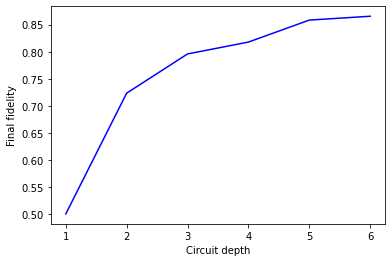

In [2]:
final_fitness = [0.5000378, 0.7233624, 0.79582274, 0.8177913, 0.8584324, 0.86553866]
depth_list = [1, 2, 3, 4, 5, 6]

plt.figure()
plt.plot(depth_list, final_fitness, 'b')
plt.ylabel('Final fidelity')
plt.xlabel('Circuit depth')
plt.show()